# UJM - Master DSC/MLDM - Deep Learning - TP3a
# Sentiment analysis with LSTM

This session is based on this source: https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras

**Associated data on claroline** : twitter.zip which contains 'Sentiment.csv'


**Sentiment Analysis:** the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re

## First we process the data
**Only keeping the necessary columns.**

In [ ]:
#We assume data to be in a directory data, change it with respect to your environment
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [ ]:
data.head()

,text,sentiment
1,rt scottwalker didnt catch the full gopdebate ...,Positive
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive
5,rt gregabbott_tx tedcruz on my first day i wil...,Positive
6,rt warriorwoman91 i liked her and was happy wh...,Negative


In [ ]:
data.shape

(10729, 2)

Next, the 'Neutral' sentiments are dropped as the goal proposed here is only to differentiate positive and negative tweets. After that, the tweets are filtered so that  only valid texts and words remain. The number of max features is defined as 2000 and we use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower()) #convert into lowercase letters
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) #remove symbols at beginning

print(data[ data['sentiment'] == 'Positive'].size) #nb of positives
print(data[ data['sentiment'] == 'Negative'].size) #nb of negatives

for idx,row in data.iterrows():  #remove rt symbols
    row[0] = row[0].replace('rt',' ')

#We define the representation vector for each sequences. We use the tokenizer package
#Each sequence is represented by  a token, a word is a token
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

#The last instruction pads each sequence with zeros at the beginning of the string representation
#such that each string has 29 characters
print(X[0])
print(X[1])

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3034681243.py:3: SyntaxWarning: invalid escape sequence '\s'
  data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) #remove symbols at beginning
/tmp/ipython-input-3034681243.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[0] = row[0].replace('rt',' ')
/tmp/ipython-input-3034681243.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[0] = row[0].replace('rt',' ')


4472
16986
[   0    0    0    0    0    0    0    0    0    0    3  360  121    1
  694    2   40   59  235   38  208    7  173 1747   13 1310 1394  735]
[  0   0   0   0   0   0   0   0   0   0   3  17 282 250   6 811 103 171
  27 135   7   1 172  13   2 232 715  18]


Next, we design the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **dropout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note softmax is used as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


We now build the train and test datasets.

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print('\n')
print(X_test.shape,Y_test.shape)

(7188, 28) (7188, 2)


(3541, 28) (3541, 2)


Here we train the Network. We should run much more than 2 epochs, but to start, we fix it at 2 epochs.

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 2, batch_size=batch_size, verbose = 2)

Epoch 1/2
225/225 - 48s - 215ms/step - accuracy: 0.8095 - loss: 0.4471
Epoch 2/2
225/225 - 40s - 179ms/step - accuracy: 0.8560 - loss: 0.3322


Extracting a validation set, and measuring score and accuracy.

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

64/64 - 3s - 46ms/step - accuracy: 0.8486 - loss: 0.3488
score: 0.35
acc: 0.85


Finally we measure the number of correct guesses.  It is clear that finding negative tweets goes very well for the Network but deciding whether is positive is not really. The "bad" results for positive tweets can be explained by the imbalanced nature of the data.

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):

    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 0)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 45.307443365695796 %
neg_acc 96.6414777497901 %


**We now predict some tweets**

In [ ]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  204  625    7  152    6   56 1039   56   47    7  152]]
1/1 - 0s - 81ms/step
negative


Test your own tweets !
**Note**: this is a basic notebook. The model requires more epochs and special attention to class imbalance, one solution could be to use more data or to start from pretrained models.

In [ ]:
# Test with your own tweets
my_tweets = [
    "Just finished my deep learning assignment! Feeling accomplished!",
    "The weather is so gloomy today, perfect for staying indoors and coding.",
    "I can't believe how terrible the customer service was at that restaurant.",
    "This new movie was absolutely mind-blowing! Must watch!",
    "Meh, the product was okay but not worth the price.",
    "Another day, another meeting that could have been an email...",
    "Just learned about LSTMs and my mind is blown! So powerful!",
    "Traffic was a nightmare today, wasted 2 hours of my life.",
    "The concert last night was phenomenal! Best night ever!",
    "Coffee machine broken again. Third time this month. Unacceptable."
]

# Get predictions only
predictions = []
for tweet in my_tweets:
    # Preprocess (same as your original code)
    tweet = tweet.lower()
    tweet = re.sub('[^a-zA-z0-9\s]', '', tweet)

    # Vectorize and pad (same as your original code)
    twt_seq = tokenizer.texts_to_sequences([tweet])
    twt_padded = pad_sequences(twt_seq, maxlen=28, dtype='int32', value=0)

    # Predict (same as your original code)
    sentiment = model.predict(twt_padded, batch_size=1, verbose=0)[0]

    # Determine prediction
    if np.argmax(sentiment) == 0:
        predictions.append("negative")
    else:
        predictions.append("positive")

# Output the predictions list
print("Predictions:", predictions)

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1204679086.py:20: SyntaxWarning: invalid escape sequence '\s'
  tweet = re.sub('[^a-zA-z0-9\s]', '', tweet)


Predictions: ['negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative']


The model is biased toward the majority class (Negative tweets) and tends to predict negatives more. The next phase will add more epochs and fix class imbalance, and use more data.

In [65]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [26]:
# ENHANCED DATA LOADING & PREPROCESSING
data = pd.read_csv('Sentiment.csv')
print(f"Total records: {len(data)}")

# Keep only text and sentiment columns
data = data[['text', 'sentiment']]

# Remove neutral sentiments
data = data[data.sentiment != "Neutral"]
print(f"After removing Neutral: {len(data)}")

# Check class distribution BEFORE processing
print("\nClass distribution before processing:")
print(data['sentiment'].value_counts())
print(f"Positive: {data[data['sentiment'] == 'Positive'].shape[0]}")
print(f"Negative: {data[data['sentiment'] == 'Negative'].shape[0]}")
print(f"Imbalance ratio: {data[data['sentiment'] == 'Negative'].shape[0] / data[data['sentiment'] == 'Positive'].shape[0]:.2f}x")


Total records: 13871
After removing Neutral: 10729

Class distribution before processing:
sentiment
Negative    8493
Positive    2236
Name: count, dtype: int64
Positive: 2236
Negative: 8493
Imbalance ratio: 3.80x


In [27]:
#Enhanced preprocessing function
def enhanced_preprocess(text):
    """Better preprocessing to preserve sentiment cues"""
    text = str(text).lower()

    # Handle contractions properly
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'ll": " will",
        "'ve": " have",
        "'re": " are",
        "'d": " would",
        "'s": " is",
        "'m": " am"
    }
    for cont, exp in contractions.items():
        text = text.replace(cont, exp)

    # Remove URLs and mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'rt\s+', '', text)  # Remove retweet markers

    # Keep important punctuation for sentiment (! and ?)
    text = re.sub(r'[^\w\s!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
data['text_clean'] = data['text'].apply(enhanced_preprocess)

# Check sample preprocessing
print("\nSample preprocessing:")
for i in range(2):
    print(f"Original: {data.iloc[i]['text']}")
    print(f"Cleaned:  {data.iloc[i]['text_clean']}")


Sample preprocessing:
Original: RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
Cleaned:  did not catch the full gopdebate last night here are some of scott is best lines in 90 seconds walker16
Original: RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …
Cleaned:  that carly fiorina is trending hours after her debate above any of the men in just completed gopdebate says she is on


In [28]:
# ENHANCED TOKENIZATION WITH MORE FEATURES

# Use MORE features (increase from 2000 to 5000)
MAX_FEATURES = 5000  # Increased from 2000
MAX_LENGTH = 50      # Increased sequence length

# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_FEATURES,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=' ',
                      char_level=False)

# Fit on ALL text data
tokenizer.fit_on_texts(data['text_clean'].values)

# Convert texts to sequences
X = tokenizer.texts_to_sequences(data['text_clean'].values)

# Pad sequences
X = pad_sequences(X, maxlen=MAX_LENGTH, padding='pre', truncating='pre')
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Using top {MAX_FEATURES} words")
print(f"Sequence length: {MAX_LENGTH}")
print(f"X shape: {X.shape}")


Vocabulary size: 10364
Using top 5000 words
Sequence length: 50
X shape: (10729, 50)


In [29]:
# HANDLE CLASS IMBALANCE

# Convert labels to numerical
data['sentiment_numeric'] = data['sentiment'].map({'Positive': 1, 'Negative': 0})
Y = data['sentiment_numeric'].values

# Split data BEFORE resampling to avoid data leakage
X_temp, X_test, y_temp, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

print(f"Training set:   {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")

Training set:   6866 samples
Validation set: 1717 samples
Test set:       2146 samples


In [33]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)

class_weight_dict = {i: class_weights[i] for i in range(2)}
print(f"\nClass weights calculated:")
print(f"  Class 0 (Negative): weight = {class_weight_dict[0]:.2f}")
print(f"  Class 1 (Positive): weight = {class_weight_dict[1]:.2f}")
print(f"  Positive class gets {class_weight_dict[1]/class_weight_dict[0]:.2f}x more importance")


Class weights calculated:
  Class 0 (Negative): weight = 0.63
  Class 1 (Positive): weight = 2.40
  Positive class gets 3.80x more importance


In [37]:
print("Before oversampling:")
print(f"  Training set: {np.sum(y_train == 1)} positive, {np.sum(y_train == 0)} negative")

Before oversampling:
  Training set: 1431 positive, 5435 negative


In [38]:
# Apply oversampling ONLY to training data
ros = RandomOverSampler(random_state=42, sampling_strategy=0.5)  # 1:2 ratio
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("\nAfter oversampling:")
print(f"  Training set: {np.sum(y_train_resampled == 1)} positive, {np.sum(y_train_resampled == 0)} negative")
print(f"  New ratio: 1:{np.sum(y_train_resampled == 0) / np.sum(y_train_resampled == 1):.1f}")


After oversampling:
  Training set: 2717 positive, 5435 negative
  New ratio: 1:2.0


In [40]:
# Use resampled data for training
X_train = X_train_resampled
y_train = y_train_resampled

# Convert to categorical for neural network
y_train_cat = to_categorical(y_train_resampled, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)


In [47]:
# new MODEL ARCHITECTURE
EMBED_DIM = 128
LSTM_UNITS = 196
DROPOUT_RATE = 0.3
model = Sequential()

# Embedding layer
model.add(Embedding(MAX_FEATURES, EMBED_DIM, input_length=MAX_LENGTH))

# Spatial dropout
model.add(SpatialDropout1D(DROPOUT_RATE))

# Bidirectional LSTM (reads text both ways)
model.add(Bidirectional(LSTM(LSTM_UNITS,
                            dropout=DROPOUT_RATE,
                            recurrent_dropout=DROPOUT_RATE,
                            return_sequences=True)))

# Second LSTM layer
model.add(LSTM(LSTM_UNITS // 2,
               dropout=DROPOUT_RATE,
               recurrent_dropout=DROPOUT_RATE))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(32, activation='relu'))
model.add(Dropout(DROPOUT_RATE / 2))

# Output layer
model.add(Dense(2, activation='softmax'))

# Custom optimizer with lower learning rate
optimizer = Adam(learning_rate=0.0005)

# Compile with class-weighted loss
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

print("Model architecture:")
model.summary()

Model architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
# TRAINING WITH MORE EPOCHS & CALLBACKS
EPOCHS = 20  # Increased from 2
BATCH_SIZE = 64

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1),
    ModelCheckpoint(
        'best_sentiment_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1)]

print(f"Training parameters:")
print(f" Epochs: {EPOCHS}")
print(f" Batch size: {BATCH_SIZE}")

Training parameters:
 Epochs: 20
 Batch size: 64


In [54]:
# Train the model
history = model.fit(
    X_train_resampled, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_cat),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5239 - loss: 0.6837 - precision: 0.5239 - recall: 0.5239
Epoch 1: val_accuracy improved from -inf to 0.77519, saving model to best_sentiment_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.5249 - loss: 0.6832 - precision: 0.5249 - recall: 0.5249 - val_accuracy: 0.7752 - val_loss: 0.4741 - val_precision: 0.7752 - val_recall: 0.7752 - learning_rate: 5.0000e-04
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8225 - loss: 0.4268 - precision: 0.8225 - recall: 0.8225
Epoch 2: val_accuracy did not improve from 0.77519
128/128 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8226 - loss: 0.4267 - precision: 0.8226 - recall: 0.8226 - val_accuracy: 0.7350 - val_loss: 0.6080 - val_precision: 0.7350 - val_recall: 0.7350 - learning_rate: 5.0000e-04
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8734 - loss: 0.3172 - precision: 0.8734 - recall: 0.8734
Epoch 3: val_accuracy improved from 0.77519 to 0.79033, saving model to best_sentiment_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.8735 - loss: 0.3171 - precision: 0.8735 - recall: 0.8735 - val_accuracy: 0.7903 - val_loss: 0.5478 - val_precision: 0.7903 - val_recall: 0.7903 - learning_rate: 5.0000e-04
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8996 - loss: 0.2576 - precision: 0.8996 - recall: 0.8996
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 4: val_accuracy improved from 0.79033 to 0.80314, saving model to best_sentiment_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8995 - loss: 0.2577 - precision: 0.8995 - recall: 0.8995 - val_accuracy: 0.8031 - val_loss: 0.4756 - val_precision: 0.8031 - val_recall: 0.8031 - learning_rate: 5.0000e-04
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9228 - loss: 0.2113 - precision: 0.9228 - recall: 0.9228
Epoch 5: val_accuracy did not improve from 0.80314
128/128 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9228 - loss: 0.2113 - precision: 0.9228 - recall: 0.9228 - val_accuracy: 0.8026 - val_loss: 0.5619 - val_precision: 0.8026 - val_recall: 0.8026 - learning_rate: 2.5000e-04
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9262 - loss: 0.1984 - precision: 0.9262 - recall: 0.9262
Epoch 6: val_accuracy did not improve from 0.80314
128/128 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9262 - loss: 0.1983 - precision: 0.9262 - recall: 0.9262 - val_accuracy: 0.7979 - val_loss: 0.5949 - val_precision: 0.7979 - val_recall: 0.797

In [55]:
# EVALUATION & VISUALIZATION
# Load model
model.load_weights('best_sentiment_model.h5')
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(
    X_test, y_test_cat, verbose=0)

print(f"Test Results:")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")

Test Results:
  Accuracy:  0.8094
  Loss:      0.4750
  Precision: 0.8094
  Recall:    0.8094


In [56]:
# Calculate F1-score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"  F1-Score:  {test_f1:.4f}")

  F1-Score:  0.8094


In [57]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 298ms/step


In [58]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.85      0.88      1699
    Positive       0.53      0.67      0.59       447

    accuracy                           0.81      2146
   macro avg       0.72      0.76      0.74      2146
weighted avg       0.83      0.81      0.82      2146



In [60]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1437  262]
 [ 147  300]]


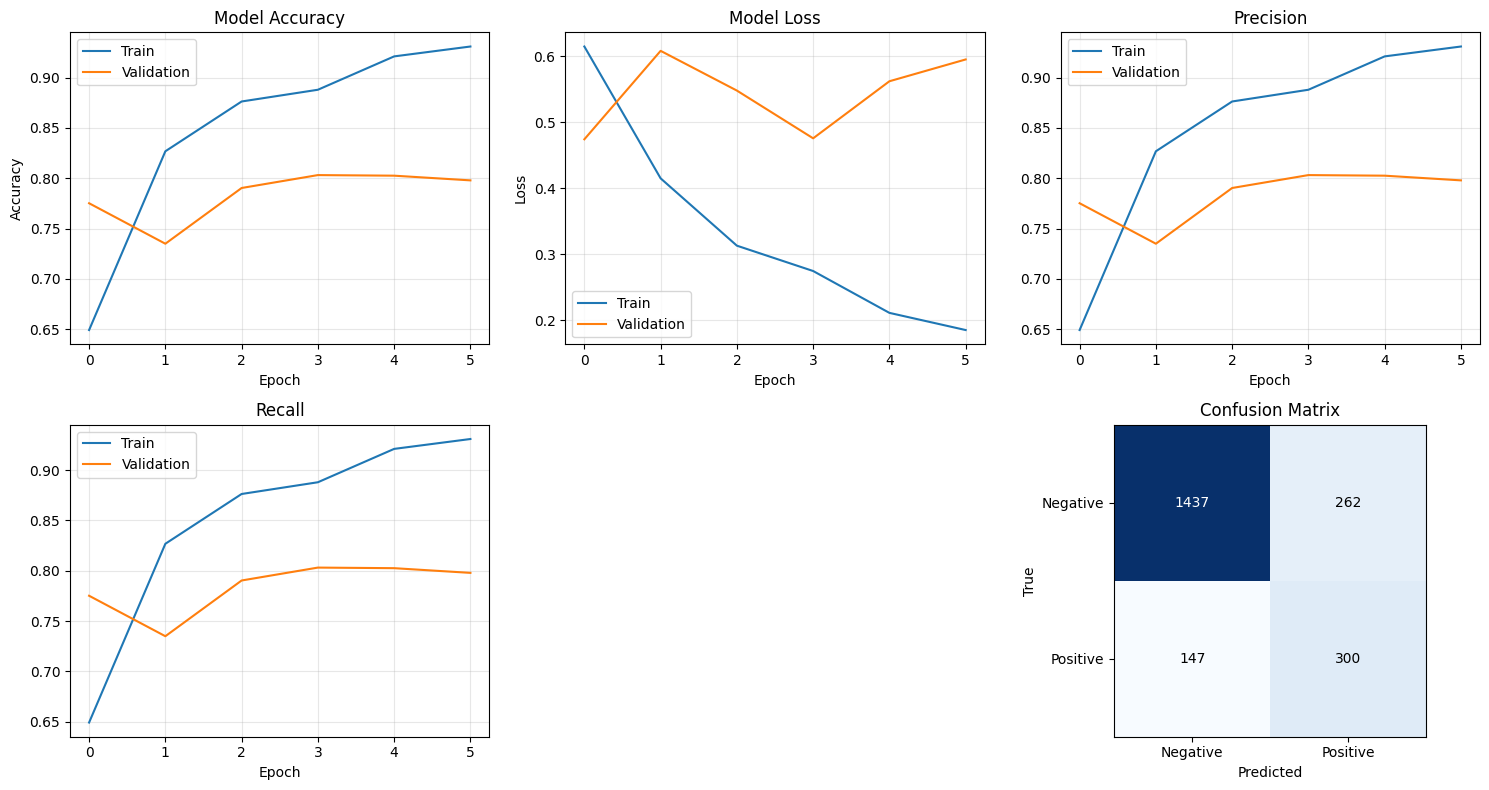

In [63]:
# VISUALIZE TRAINING HISTORY
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train')
axes[0, 1].plot(history.history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[0, 2].plot(history.history['precision'], label='Train')
axes[0, 2].plot(history.history['val_precision'], label='Validation')
axes[0, 2].set_title('Precision')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Recall
axes[1, 0].plot(history.history['recall'], label='Train')
axes[1, 0].plot(history.history['val_recall'], label='Validation')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'])
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].axis('off')

# Confusion Matrix Heatmap
im = axes[1, 2].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1, 2].set_title('Confusion Matrix')
axes[1, 2].set_xticks([0, 1])
axes[1, 2].set_yticks([0, 1])
axes[1, 2].set_xticklabels(['Negative', 'Positive'])
axes[1, 2].set_yticklabels(['Negative', 'Positive'])
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('True')

# Add text annotations to confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[1, 2].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()
